In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
# Define paths to your training and testing datasets
train_data_path = "/content/drive/MyDrive/bda/data_ck+48/train"
test_data_path = "/content/drive/MyDrive/bda/data_ck+48/test"


In [3]:
def load_data(data_path):
    images = []
    labels = []

    for emotion_folder in os.listdir(data_path):
        for image_filename in os.listdir(os.path.join(data_path, emotion_folder)):
            image_path = os.path.join(data_path, emotion_folder, image_filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (48,48))  # VGG16 input size
            images.append(image)
            labels.append(emotion_folder)

    return np.array(images), np.array(labels)

# Load training data
X_train, y_train = load_data(train_data_path)

# Load testing data
X_test, y_test = load_data(test_data_path)


In [4]:

def extract_vgg16_features(X):
    base_model = VGG16(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

    features = model.predict(X)

    return features


In [5]:
X_train_features = extract_vgg16_features(X_train)
X_test_features = extract_vgg16_features(X_test)


11/11 [==============================] - 1s 61ms/step


In [6]:
# Convert labels to numeric values
label_to_idx = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_numeric = np.array([label_to_idx[label] for label in y_train])
y_test_numeric = np.array([label_to_idx[label] for label in y_test])

# Create an XGBoost model
model = xgb.XGBClassifier()
# Reshape the feature vectors
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

# Train the XGBoost model
model = xgb.XGBClassifier(
   n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.1,
    min_child_weight=7,
    gamma=0.1,
    reg_lambda=1,
    reg_alpha=0,
    objective='multi:softmax',  # Use 'multi:softprob' for probability outputs
    eval_metric='mlogloss',
    scale_pos_weight=3,

    seed=50
)
model.fit(X_train_features, y_train_numeric)

# Train the model
model.fit(X_train_features, y_train_numeric)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:34:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:34:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [7]:
# Make predictions on the testing data
y_pred = model.predict(X_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test_numeric, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.744807121661721


In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


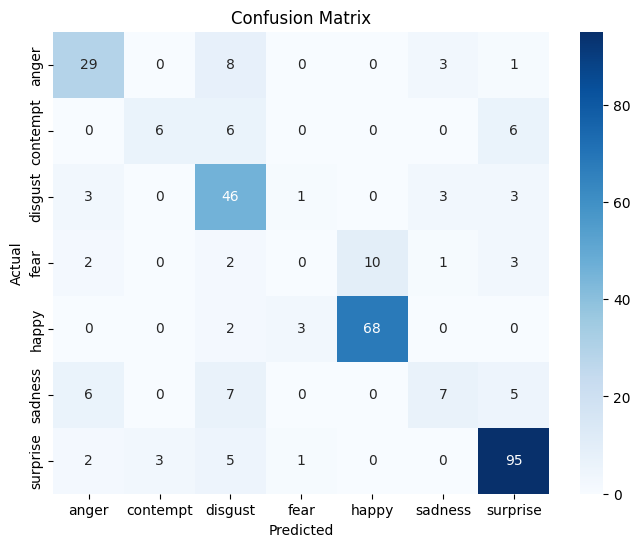

In [9]:
# Calculate confusion matrix
confusion = confusion_matrix(y_test_numeric, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
